<h1><center> MANAGEMENT AND ANALYSIS OF PHYSICS DATASET (mod.B)  </center></h1>

<h1><center> Final project :  Analysis of Covid-19 papers  </center></h1>


<h2><center> Date : 23/09/2020 , University of Padua </center></h2>

<h3><center> Authors : Camilla Quaglia (1242830) , Edoardo Antonaci (1234431) and Walter Zigliotto  (1230665) </center></h3>

# First part

### Packages importation

In [1]:
from dask.distributed import Client
from dask import delayed
import dask
import time
import json
import os
import dask.bag as db
import re
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

###  Word Counter Distributed Algorithm

This section is dedicated to the implementation of the so called 'Word counter distributed algorithm', a distributed algorithm to count the occurrences of words in papers. The analysis is performed over a dataset composed by 1000 research papers on COVID-19. Each file is a .json file. 



The algorithm is divided in: 
* Map phase : For each document Di , produce the set of intermediate pairs (w, cp(w)) ,one for each word w ∈ Di , where cp(w) is the number of occurrences of w in Di .

* Reduce phase : For each word w, gather all the previous pairs (w, cp(w)) and return
the final pair (w, c(w)) where c(w) is the number of occurrences of w for all the
P n
Documents. In other words, c(w) is equal to k=1 cp k (w)

In the following cell a local Cluster is set up.
\
Dask allows to create a local cluster, with a sheduler and some workers the current machine. In this case 4 workers can be crated, each one with 2 cores.

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37747 Dashboard: http://127.0.0.1:42203/status,Cluster Workers: 4 Cores: 8 Memory: 7.25 GB


Fistly a new directory is created, with the content of the original .json files in one single line. Then the data so formatted are loaded.

In [4]:
path_to_json = 'data/papers_in_json/'

files = [path_to_json+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

path_to_one_line_json='data/papers_in_one_line_json/'

for i in range(len(files)):
    f = open(files[i],"r")
    f_one_line = open(path_to_one_line_json+str(i)+".json","w+")
    s = f.read()
    s = s.replace('\t','')
    s = s.replace('\n','')
    s = s.replace(" ","")
    
    f_one_line.write( str( re.split("[\n]", s )[0] ) )


f_one_line.close()
f.close() 

In [5]:
filename = os.path.join('data', 'papers_in_one_line_json', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10) 

With the following function, named 'merge', the  divided paragraphs  contained into the body-text of the papers are concatenated togheder.

In [6]:
def merge(record):
    text=''
    for rec in record:
        text+=rec['text']
    return text

texts = js.pluck("body_text").map(merge)
texts.take(1) # body-text of the first paper


('The human bocavirus (HBoV) was initially discovered in clinical samples from the respiratory tract of children suffering from respiratory infections of unknown etiology. 1 To date, HBoV is the fourth most detected respiratory virus, but as there is still no animal model or a broadly convertible cell culture available, Koch\'s modified postulates have not yet been completely fulfilled. 3 Nevertheless, HBoV is the second parvovirus that is capable of infecting humans with the potential to cause clinical disease. Until HBoV was discovered, parvovirus B19 was the sole human parvovirus, which can hardly be cultured in in vitro cell cultures, likely because it strongly depends on the optimal cell cycle phase. [4] [5] [6] [7] [8] [9] [10] [11] [12] [13] This latter fact hampered the development of potent and specific antivirals, tenacity studies, and the development of disinfectants active against human parvoviruses as surrogate pathogens with animal pathogenicity were used. The discovery o

Before applying the 'Words counter' algorithm we have to 'sanitize' our paper, removing the stop-words. This is done though the stopwords dictionary. The latter is imported in the following cell, from Natural language toolkit. \
The used procedure to remove stop-word from the text is described at the following link https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python

In [7]:
from nltk.corpus import stopwords

In [8]:
list_stopwords = stopwords.words("english")
list_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [9]:
list_stopwords = stopwords.words("english")

# add more words to the stop-words list
for word in ['et','al','also','may','fig','figure']:
    list_stopwords.append(word)

pattern = re.compile(r'\b(' + r'|'.join(list_stopwords) + r')\b\s*')


In [10]:
def cleaner(text):

    text = re.sub('\W+',' ', text)                  # delete special characters (.,!)
    text = re.sub(r'\b[0-9]+\b\s*', ' ', text)      # delete numbers
    text = text.lower()                             # set all lowercase
    text = re.sub(r"\b[a-zA-Z]\b", "", text)        # remove single characters
    text = pattern.sub('', text)                    # remove stop-words
    wordlist = text.split()                         # split text in strings
    
    return wordlist

In [11]:
type(texts) # texts (papers body-text) is a Bag file!!

dask.bag.core.Bag

In [12]:
text_clean = texts.map(cleaner) 
map_phase = text_clean.map(Counter)

The map phase of the algorithm is now computed: for each document , the set of pairs like  (word, number of occurences in the document)
 is avaible. \
 To compute this the 'Counter' is used. It is a container that keep track of how many times equivalent values (words in this case) appear. The description is avaiable here https://pymotw.com/2/collections/counter.html . 
 \
 \
 Also the execution time to compute this Map phase is printed.

In [13]:
%%time
results = map_phase.compute()

CPU times: user 7.62 s, sys: 771 ms, total: 8.39 s
Wall time: 17.4 s


In [14]:
results[2]


Counter({'influenza': 53,
         'infectious': 1,
         'disease': 7,
         'affecting': 1,
         'mainly': 1,
         'upper': 1,
         'respiratory': 6,
         'tract': 2,
         'worldwide': 1,
         'virus': 16,
         'causes': 2,
         'three': 1,
         'five': 5,
         'million': 1,
         'severe': 12,
         'cases': 33,
         'estimated': 1,
         'deaths': 3,
         'annually': 1,
         'european': 2,
         'union': 1,
         'annual': 1,
         'attributable': 1,
         'however': 2,
         'mortality': 3,
         'tip': 1,
         'iceberg': 1,
         'terms': 1,
         'burden': 3,
         'since': 1,
         'decrease': 1,
         'functional': 1,
         'status': 3,
         'increased': 4,
         'dependency': 1,
         'elderly': 4,
         'estimating': 1,
         'caused': 4,
         'difficult': 1,
         'many': 1,
         'require': 1,
         'medical': 3,
         'care': 4,
      

In the following cell a barplot of the 10 most frequent words in each paper is created. The graph is avaiable for the first 5 papers.

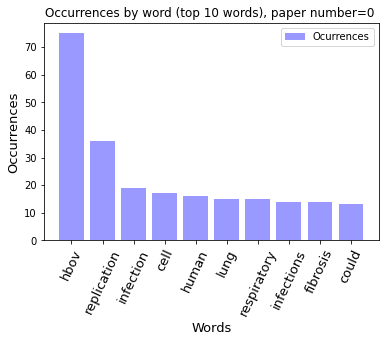

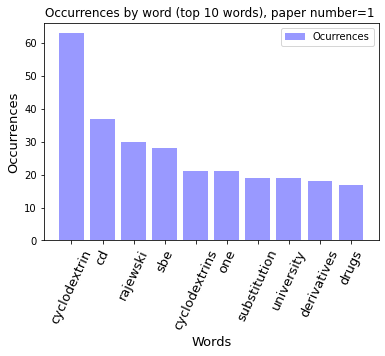

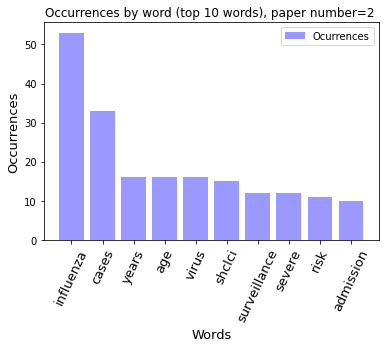

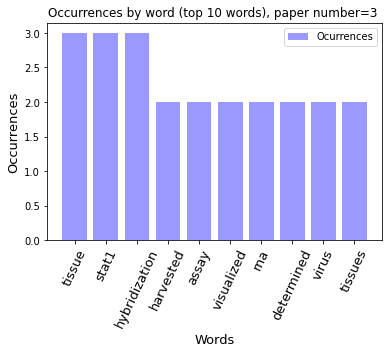

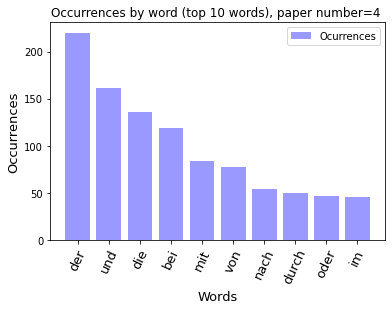

In [15]:
for i in range(5):
    total = list(results[i].keys()), list(results[i].values()) 
    data = pd.DataFrame(total)
    data = data.T
    n_groups = len(data)


    data.columns = ["a","b"]
    data = data.sort_values(["b"],ascending=False)
    data = data.head(10)
    words = data["a"]
    occurences = data["b"]

    fig,ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.25

    opacity = 0.4

    graph = plt.bar(words, occurences,
                alpha=opacity,
                 color='b',
                 label='Ocurrences')


    plt.ylabel('Occurrences',size=13)
    plt.xlabel('Words',size=13)
    plt.xticks(rotation=90,size=13)
    plt.xticks(rotation=65)
    plt.title('Occurrences by word (top 10 words), paper number={} '.format(i),size=12)
    plt.legend()
    plt.show()


The reduce phase is computed; to get the occurrence of each word over all the papers the flatten() function is applyed to the sanitized text. \
Like before, the execution time is printed.

In [16]:
reduce_phase = text_clean.flatten().frequencies(sort=True)

In [17]:
%%time
res_reduce = reduce_phase.compute()

CPU times: user 8.57 s, sys: 968 ms, total: 9.54 s
Wall time: 21.3 s


In [18]:
res_reduce 

[('patients', 12458),
 ('cells', 11604),
 ('virus', 9211),
 ('infection', 8001),
 ('study', 7632),
 ('using', 7394),
 ('used', 7091),
 ('cell', 6550),
 ('data', 6540),
 ('viral', 6346),
 ('disease', 6270),
 ('one', 6069),
 ('two', 5995),
 ('protein', 5771),
 ('time', 5595),
 ('results', 5264),
 ('however', 5220),
 ('high', 4759),
 ('studies', 4700),
 ('different', 4688),
 ('clinical', 4658),
 ('human', 4567),
 ('cov', 4304),
 ('based', 4296),
 ('analysis', 4167),
 ('treatment', 4148),
 ('covid', 4130),
 ('cases', 4129),
 ('group', 4101),
 ('sars', 4085),
 ('number', 4083),
 ('could', 4067),
 ('use', 4013),
 ('rna', 4010),
 ('well', 3944),
 ('associated', 3891),
 ('specific', 3868),
 ('first', 3862),
 ('viruses', 3837),
 ('control', 3780),
 ('respiratory', 3763),
 ('infected', 3762),
 ('expression', 3756),
 ('found', 3706),
 ('model', 3705),
 ('health', 3610),
 ('including', 3446),
 ('reported', 3427),
 ('shown', 3414),
 ('system', 3411),
 ('response', 3371),
 ('risk', 3272),
 ('influen

To visualize this result, a barplot of the 40 most frequent words over all the 1000 papers is obtained.

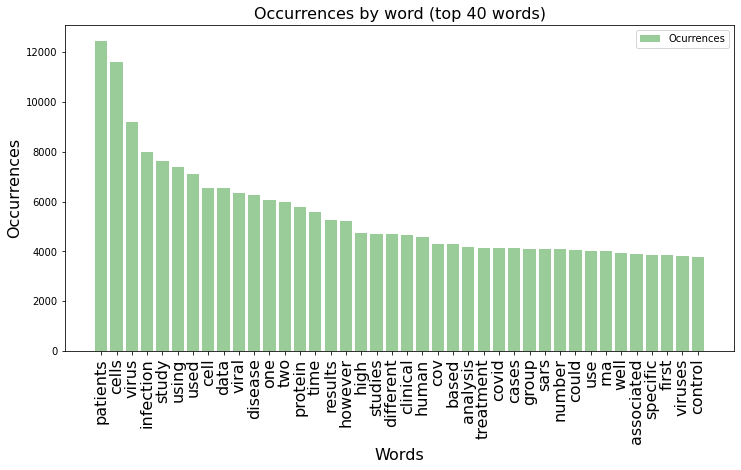

In [19]:
df = pd.DataFrame(res_reduce)
df.columns= ["c","d"]
df = df.sort_values(["d"],ascending=False)
df = df.head(40)
words = df["c"]
occurences = df["d"]

plt.figure(figsize=(12, 6))

bar_width = 0.25
opacity = 0.4

graph = plt.bar(words, occurences,
                alpha=opacity,
                 color='g',
                 label='Ocurrences')


plt.ylabel('Occurrences',size=16)
plt.xlabel('Words',size=16)
plt.xticks(rotation=90,size=16)
plt.title('Occurrences by word (top 40 words)',size=16)
plt.legend()
plt.show()

#### Changes of the number of partions and workers

The previous algorithm is run by changing the number of workers and the
number of partitions. For each run the execution time is printed. Let's see how the latter changes!


Firsty we change the number of partition, leaving the number of workers untouched. 

In [20]:
partition_time = []
partitions = [1,5,10,30,50,100,200,300]
for n in partitions:
    print('number of partitions:',n)
    
    start = time.time()
    
    #import the data
    filename = os.path.join('data', 'papers_in_one_line_json', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(n)
    
    texts = js.pluck("body_text").map(merge) 
    text_clean = texts.map(cleaner) 
    
    #map_phase
    map_phase = text_clean.map(Counter)
    
    #reduce_phase
    reduce_phase = text_clean.flatten().frequencies(sort=True)
    
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end = time.time()
    
    print('Execution time:',end-start,'\n')
    partition_time.append(end-start)


number of partitions: 1
Execution time: 56.411343812942505 

number of partitions: 5
Execution time: 34.192293643951416 

number of partitions: 10
Execution time: 29.46652913093567 

number of partitions: 30
Execution time: 29.675146102905273 

number of partitions: 50
Execution time: 29.667146921157837 

number of partitions: 100
Execution time: 30.704809188842773 

number of partitions: 200
Execution time: 34.70633506774902 

number of partitions: 300
Execution time: 34.81805372238159 



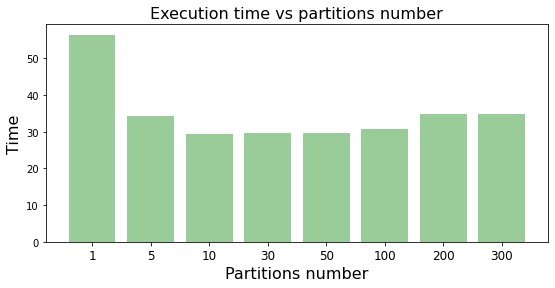

In [21]:
plt.figure(figsize=(9,4))
bar_width = 0.15
plt.bar(range(len(partitions)),partition_time,alpha=0.4,color='g')
plt.xlabel('Partitions number',size=16)
plt.ylabel('Time',size=16)
plt.title('Execution time vs partitions number',size=16)
plt.xticks(range(len(partitions)),partitions,size=12)
plt.show() 

In the above graph we see that initially the time decreases as the number of partitions increases (from 1 up to 30) and then we have a little increasing in time.
\
We can say that it is not convenient having too many too few partititions:
\
even if partitioning means dividing data and compute them into smaller units to improve performance, we have to take into account that each operation on each partition takes the scheduler a time ~ $ 10^{-4} s$  to process.

In [22]:
client.close() 

Here we fix the number of partitions at the value for which the computation time is lower (30 partitions) and change the number of workers.

In [23]:
worker_time = []
workers = [1,2,3,4]
for w in workers:
    print('Workers:',w)
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    
    start = time.time()
    
    #import the data
    filename = os.path.join('data', 'papers_in_one_line_json', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(30)
    
    texts = js.pluck("body_text").map(merge)
    text_clean = texts.map(cleaner) 
    
    #map_phase
    map_phase = text_clean.map(Counter)
    
    #reduce_phase
    reduce_phase = text_clean.flatten().frequencies(sort=True)
    
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end = time.time()
    
    print('Execution time:',end-start,'\n') 
    worker_time.append(end-start) 

Workers: 1
Execution time: 65.91214966773987 

Workers: 2
Execution time: 38.42133545875549 

Workers: 3
Execution time: 30.443515062332153 

Workers: 4
Execution time: 30.122947931289673 



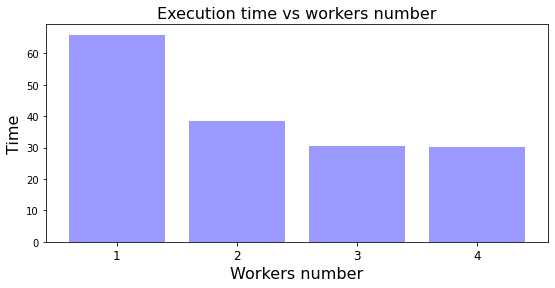

In [24]:
plt.figure(figsize=(9,4))
plt.bar(range(len(workers)),worker_time,alpha=0.4,color='b')
plt.xlabel('Workers number',size=16)
plt.ylabel('Time',size=16)
plt.title('Execution time vs workers number',size=16) 
plt.xticks(range(len(workers)),workers,size=12) 
plt.show()


As the number of workers increases, the computation time decreases significanlty. 
\
\
More precisily we can think about the computational time taken in the analysis as the 'overhead'. The 'overhead' can be due:

* to the scheduler , as discussed before , in processing objects that has to be sent to the workers

* to the speed of the connection between the cluster's nodes

In [25]:
client.close()

Now we perform a similar analysis than before: how the computational time changes as the number of both the partitions and workers changes. 

In [26]:
def comp_time(w,p):
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    start = time.time()
    
    #import the data
    filename = os.path.join('data', 'papers_in_one_line_json', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(p)
    
    texts = js.pluck("body_text").map(merge)
    text_clean = texts.map(cleaner) 
    
    #map_phase
    map_phase = text_clean.map(Counter)
    
    #reduce_phase
    reduce_phase = text_clean.flatten().frequencies(sort=True)
    
     
    map_phase, reduce_phase = dask.compute(map_phase, reduce_phase)

    end = time.time()
    client.close()
    return end-start

In [27]:
workers = [1,2,3,4]
partitions = [1,5,20,50,100] # with the same partitions as before
                                     #the kernel stop working
t = np.zeros((len(workers),len(partitions)))
for w in range(len(workers)):
    for p in range(len(partitions)):
        t[w][p] = comp_time(workers[w],partitions[p])

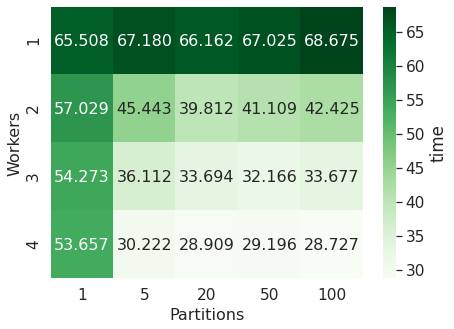

In [28]:
df_grid = pd.DataFrame(t,workers,partitions)
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_grid,annot=True, annot_kws={"size": 16},fmt=".3f",
           cbar_kws={'label':'time'},cmap="Greens")
plt.ylabel('Workers',size=16) 
plt.xlabel('Partitions',size=16)   
plt.show()

The optimal execution time is for 4 workers and 20 partitions. This is in accordance with the considerations we did before. 
\
We notice that with only one worker the execution time gets high as the number of partition is high. 

In [29]:
client.close()